In [10]:
import uproot # type: ignore
import pandas as pd # type: ignore
import numpy as np # type: ignore
import awkward as ak # type: ignore
import matplotlib # type: ignore
from mpl_toolkits.mplot3d import Axes3D # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
import math
import csv
import math
import seaborn as sns # type: ignore
import sympy as smp # type: ignore
import sympy.stats # type: ignore
from scipy import stats,signal,ndimage,special,fft # type: ignore
from scipy.optimize import curve_fit # type: ignore
from scipy.integrate import quad # type: ignore
from mpl_toolkits.axes_grid1 import make_axes_locatable # type: ignore

Open and read input root file, setup data frame

In [11]:
tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/2p2h_nonMEC_truth.root")
tracks["TruthTree"].show()
tracks["TruthTree"].keys()

branches = tracks["TruthTree"].arrays()[0]
file_index = branches['file_index']
print("File indeces: ", np.unique(file_index))

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
true_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
true_angle_y         | std::

Loop through each file index

In [12]:
p_theta = []
candidate_files = []
hammer = 0
#Function to find angle between 2 (momentum) vectors
#Using dot product
def mag(x):
    return np.sqrt(np.sum(i ** 2 for i in x))

def theta(track1, track2):
    cos = np.dot(track1, track2) / (mag(track1) * mag(track2))
    cos = np.clip(cos, -1, 1)
    #p_theta = np.arccos(cos)
    return cos

#Loop through each file

for file_idx in np.unique(file_index):
    
    true_energy = branches['true_energy'][file_index == file_idx]
    true_p_x = branches['true_p_x'][file_index == file_idx]
    true_p_y = branches['true_p_y'][file_index == file_idx]
    true_p_z = branches['true_p_z'][file_index == file_idx]
    true_p_mag = branches['true_p_mag'][file_index == file_idx]
    true_length = branches['true_length'][file_index == file_idx]
    true_angle = branches['true_angle'][file_index == file_idx]
    true_angle_rot = branches['true_angle_rot'][file_index == file_idx]
    true_angle_incl = branches['true_angle_incl'][file_index == file_idx]
    true_angle_x = branches['true_angle_x'][file_index == file_idx]
    true_angle_y = branches['true_angle_y'][file_index == file_idx]
    true_angle_z = branches['true_angle_z'][file_index == file_idx]
    true_track_start_x = branches['true_track_start_x'][file_index == file_idx]
    true_track_start_y = branches['true_track_start_y'][file_index == file_idx]
    true_track_start_z = branches['true_track_start_z'][file_index == file_idx]
    true_track_end_x = branches['true_track_end_x'][file_index == file_idx]
    true_track_end_y = branches['true_track_end_y'][file_index == file_idx]
    true_track_end_z = branches['true_track_end_z'][file_index == file_idx]
    true_pdg = branches['true_pdg'][file_index == file_idx]
    true_nproton = branches['true_nproton'][file_index == file_idx]
    spill_index = branches['spill_index'][file_index == file_idx]
    event = branches['event'][file_index == file_idx]
    run = branches['run'][file_index == file_idx]
    subrun = branches['subrun'][file_index == file_idx]
    caf_file_name = branches['caf_file_name'][file_index == file_idx]

    #Loop through each event in the file
    for ev in event:

        true_nproton_ev = true_nproton[event == ev]
        true_pdg_ev = true_pdg[event == ev]
        true_start_x_ev = true_track_start_x[event == ev]
        true_start_y_ev = true_track_start_y[event == ev]
        true_start_z_ev = true_track_start_z[event == ev]
        true_end_x_ev = true_track_end_x[event == ev]
        true_end_y_ev = true_track_end_y[event == ev]
        true_end_z_ev = true_track_end_z[event == ev]

        x_track = []
        y_track = []
        z_track = []

        #Loop through each particle
        for i in range(len(true_start_z_ev)):
            if true_pdg_ev[i] == 2212:
                x_track.append(true_end_x_ev[i] - true_start_x_ev[i])
                y_track.append(true_end_y_ev[i] - true_start_y_ev[i])
                z_track.append(true_end_z_ev[i] - true_start_z_ev[i])
        
        #Compare angles for every combination of protons in events with >=2 protons
        #Double check this process with len of 2,3,4,5
    for i in range(len(z_track) - 1):
        for j in range(i+1, len(z_track)):
            track1 = [x_track[i], y_track[i], z_track[i]]
            track2 = [x_track[j], y_track[j], z_track[j]]
            angle = theta(track1, track2)
            if angle <= -0.95:
                candidate_files.append(file_idx)
            p_theta.append(angle)


/tmp/ipykernel_2030868/1315991327.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum(i ** 2 for i in x))


Files with candidate events:  [ 35 132 558 646 646 813]


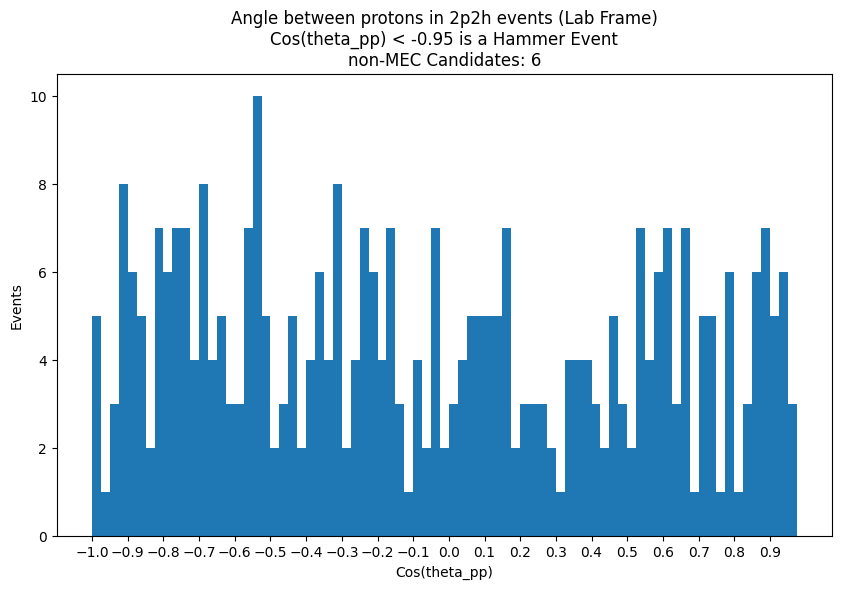

In [13]:
#candidates = len(np.unique(np.array(candidate_files)))
candidates = 0
for value in p_theta:
    if value < -0.95:
        candidates += 1
print("Files with candidate events: ", (np.array(candidate_files)))
fig = plt.figure(figsize=(10,6))
n, bins, edges = plt.hist(p_theta, bins=np.arange(-1.0, 1.0, 0.025))
plt.xticks(np.arange(-1.0, 1.0, 0.1))
plt.xlabel("Cos(theta_pp)")
plt.ylabel("Events")
plt.title("Angle between protons in 2p2h events (Lab Frame)\nCos(theta_pp) < -0.95 is a Hammer Event\nnon-MEC Candidates: %i" %candidates)
plt.show()